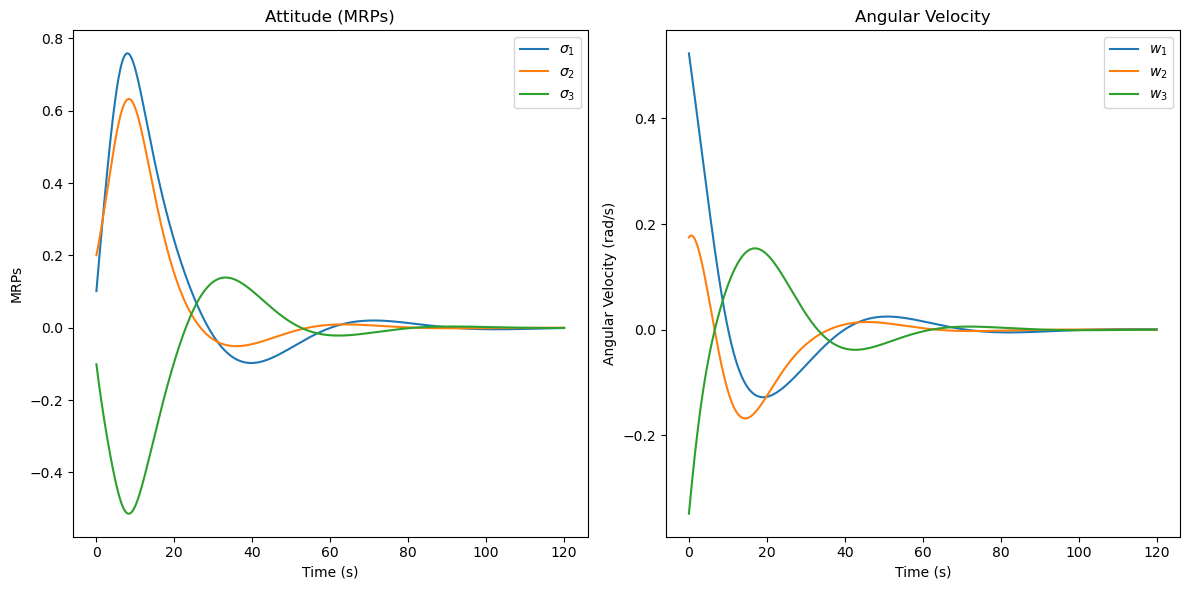

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
I = np.diag([100, 75, 80])  # Moment of inertia matrix
k = 5  # Proportional control gain
P = 10 * np.eye(3)  # Control law matrix

# Initial conditions
sigma_0 = np.array([0.1, 0.2, -0.1])  # Initial MRP
w_0 = np.array([30, 10, -20])  # Initial angular velocity in deg/s
w_0 = (np.pi / 180) * w_0  # Convert to rad/s

# Simulation parameters
dt = 0.01  # Time step
t_span = np.arange(0, 120, dt)  # Time span for simulation
n_steps = len(t_span)

# Initialize arrays to store results
sigma_history = np.zeros((n_steps, 3))
w_history = np.zeros((n_steps, 3))

# Simulate spacecraft attitude control
sigma = sigma_0
w = w_0
for i in range(n_steps):
    # Compute control torque
    control_torque = -k * sigma - P @ w
    
    # Update angular velocity using the moment of inertia
    w_dot = np.linalg.inv(I) @ (control_torque - np.cross(w, I @ w))
    w += w_dot * dt
    
    # Update attitude using MRP kinematics
    B_sigma = 0.25 * ((1 - np.linalg.norm(sigma, 2) ** 2) * np.eye(3) + 2 * np.outer(sigma, sigma) + 2 * np.cross(sigma, sigma))
    sigma_dot = B_sigma @ w
    sigma += sigma_dot * dt
    
    # Store results
    sigma_history[i] = sigma
    w_history[i] = w

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(t_span, sigma_history)
plt.xlabel('Time (s)')
plt.ylabel('MRPs')
plt.legend(['$\sigma_1$', '$\sigma_2$', '$\sigma_3$'])
plt.title('Attitude (MRPs)')

plt.subplot(122)
plt.plot(t_span, w_history)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend(['$w_1$', '$w_2$', '$w_3$'])
plt.title('Angular Velocity')

plt.tight_layout()
plt.show()
